# Analysis of Test Set 1
This notebook allows for the analysis ofthe AF scores in Test Set 1. Scroll down to see the chemical structures and the associated AF scores (with standard deviation). 

In [1]:
import glob
import math
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
from matplotlib.pyplot import *
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import host_subplot


 Define functions:

In [2]:
# Function to check if a value can be converted to a float.
def is_float(string: any) -> bool:
    if string is None:
        return False
    try:
        float(string)
        return True
    except ValueError:
        return False

# Function to extract all properties from an sdf file. (takes regex paths as input) 
def extract_properties_from_sdf(pathname):
    if not os.path.isfile(pathname):
        print("ERROR: file '%s' is missing!" % pathname)
    pattern = re.compile("^> *<.*>$")
    basename = os.path.basename(pathname)
    if not '_out.sdf' in basename:
        raise ValueError("Attempt to extract properties from file that is not an '_out.sdf file!")
    if not '-' in basename or basename.count('-') != 1:
        raise ValueError("Attempt to extract repetition number from malformulated filename '%s'!" % pathname)
    name_parts = basename.replace('_out.sdf','').rpartition('-')
    all_values = {}
    all_values["NAME"] = name_parts[0]
    all_values["REPETITION"] = name_parts[2]
    with open(pathname, "r") as input_file:
        lines = input_file.readlines()
        for index, line in enumerate(lines):
            if pattern.match(line):
                property_name = re.split('<|>', line)[2]
                value_str = lines[index + 1].rstrip()
                if is_float(value_str):
                    all_values[property_name] = float(value_str)
                else:
                    all_values[property_name] = value_str
    return all_values


# Function for plotting the fitness ascore and its components (descriptors and weights) 
# in two subplots so that the role of both descriptors and weights can be detected visually.
def plot_fitness_and_components(df_to_plot):
    rows_descriptors=['DESCRIPTOR_1', 'DESCRIPTOR_2', 'DESCRIPTOR_3', 'FITNESS']
    rows_weights=['WEIGHT_1', 'WEIGHT_2', 'WEIGHT_3', 'WEIGHT_4']
    descriptors_df=df_to_plot[rows_descriptors]
    weights_df=df_to_plot[rows_weights]
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [2, 1]})
    descriptor_styles = {
        'DESCRIPTOR_1': {'color': 'green', 'linestyle': '--', 'marker': 's', 'legend': r'$D_{1}$'},
        'DESCRIPTOR_2': {'color': 'blue', 'linestyle': '--', 'marker': 'D', 'legend': r'$D_{2}$'},
        'DESCRIPTOR_3': {'color': 'orange', 'linestyle': '--', 'marker': '^', 'legend': r'$D_{3}$'},
        'FITNESS': {'color': 'red', 'linestyle': '-', 'marker': 's', 'legend': 'AF'}
    }

    # First subplot
    for column in descriptors_df.columns:
        style = descriptor_styles.get(column, {'color': 'black', 'linestyle': '-', 'marker': 'o', 'legend': column})
        axs[0].plot(descriptors_df.index, descriptors_df[column], color=style['color'], linestyle=style['linestyle'], marker=style['marker'], label=style['legend'])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Descriptor Value')
    axs[0].set_title('')
    axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    #axs[0].set_ylim(-1, 20)  # Set y-axis range
    axs[0].legend()
    axs[0].grid(True, linestyle='--')
    
    # Define the styles and legend names for the second subplot
    weight_styles = {
        'WEIGHT_1': {'color': 'cyan', 'linestyle': ':', 'marker': 'D', 'markersize': 8, 'legend': r'$w_{1}$'},
        'WEIGHT_2': {'color': 'brown', 'linestyle': ':', 'marker': 'v', 'legend': r'$w_{2}$'},
        'WEIGHT_3': {'color': 'magenta', 'linestyle': ':', 'marker': 'o', 'legend': r'$w_{3}$'},
        'WEIGHT_4': {'color': 'black', 'linestyle': ':', 'marker': 'x', 'legend': r'$w_{4}$'}
    }
    
    # Second subplot
    for column in weights_df.columns:
        style = weight_styles.get(column, {'color': 'black', 'linestyle': '-', 'marker': 'o', 'legend': column})
        axs[1].plot(weights_df.index, weights_df[column], color=style['color'], linestyle=style['linestyle'], marker=style['marker'], markersize=style.get('markersize', 6), label=style['legend'])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Weight Value')
    axs[1].set_title('')
    axs[1].set_ylim(0, 1.1)  # Set y-axis range
    
    # Set font properties for X-axis ticks
    font_properties = font_manager.FontProperties(family='Arial', weight='bold', size=12)
    for label in axs[1].get_xticklabels():
        label.set_fontproperties(font_properties)
    
    axs[1].legend()
    axs[1].grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()


# Function to plot the data for a specific catalyst (i.e., all data with the given 'NAME' value).
def plot_one_series(series_name):
    plot_fitness_and_components(df_all_evaluations.loc[df_all_evaluations['NAME'].eq(series_name)])


# Prints the values of the columns given as argument for the group with the given name.
def get_values_for_series(column_names, group_name):
    print(df_all_evaluations.loc[df_all_evaluations['NAME'].eq(group_name)][column_names])
    

In [3]:
# Collect paths to all the sdf files (excluding HQF data) of test set 1 in 'pathnames' variable.
pathnames = sorted(glob.glob('*[!HQF]/*_out.sdf'))
print("Found %d _out.sdf files" % len(pathnames))

Found 30 _out.sdf files


In [4]:
# create dataframe with the name, descriptors, wights and fitness data.
allMolsData = []
for pathname in pathnames:
    molData = extract_properties_from_sdf(pathname)
    if not 'FITNESS' in molData:
        print("WARNING: Ignoring pathname '%s': fitness value not found! " % pathname)
        continue;
    allMolsData.append(molData)
    
df_all_evaluations = pd.DataFrame(allMolsData)
df_all_evaluations

,NAME,REPETITION,FrozenCore-PM6_ENERGY,RMSD_CONF_CG-CS,RMSD_CONF_GO-CS,UID,freeEnergyA,freeEnergyF,freeEnergyE,freeEnergyC,...,DG_referenceSynt,boltzmann_constant,avogadro_number,jmol_to_kcalmol,temp,kT,magnitude1,magnitude2,magnitude3,magnitude4
0,H0,0,741.385,0.365095,0.0,,-2513.177021,-2513.159277,-2513.177021,-2167.886551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H0,1,742.293,2.497437,0.0,,-2513.176872,-2513.159276,-2513.176872,-2167.886491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H0,2,742.576,0.453686,0.0,,-2513.177038,-2513.159372,-2513.177038,-2167.886506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H0,3,740.971,2.861585,0.0,,-2513.177004,-2513.154249,-2513.177004,-2167.886516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H0,4,740.184,2.858745,0.0,,-2513.176997,-2513.159355,-2513.176997,-2167.886536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H0,5,740.001,0.879095,0.0,,-2513.176977,-2513.159355,-2513.176977,-2167.886584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,HC1Ph,0,24.278,1.317653,0.0,,-2425.343048,-2425.318769,-2425.343048,-2080.083528,...,0.022607,1.380660e-23,6.022140e+23,0.000239,313.15,0.622309,1.432908,2.865816,4.298724,5.731632
7,HC1Ph,1,23.814,3.056643,0.0,,-2425.336818,-2425.324507,-2425.336818,-2080.085984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,HC1Ph,2,24.993,1.095028,0.0,,-2425.340416,-2425.317565,-2425.340416,-2080.086004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,HC1Ph,3,25.148,1.039172,0.0,,-2425.340426,-2425.317624,-2425.340426,-2080.085999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sort by the value of the 'FITNESS'

In [5]:
sorted_index_1 = df_all_evaluations['FITNESS'].sort_values().index
df_all_evaluations_sorted = df_all_evaluations.loc[sorted_index_1]
df_all_evaluations_sorted

,NAME,REPETITION,FrozenCore-PM6_ENERGY,RMSD_CONF_CG-CS,RMSD_CONF_GO-CS,UID,freeEnergyA,freeEnergyF,freeEnergyE,freeEnergyC,...,DG_referenceSynt,boltzmann_constant,avogadro_number,jmol_to_kcalmol,temp,kT,magnitude1,magnitude2,magnitude3,magnitude4
1,H0,1,742.293,2.497437,0.0,,-2513.176872,-2513.159276,-2513.176872,-2167.886491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H0,3,740.971,2.861585,0.0,,-2513.177004,-2513.154249,-2513.177004,-2167.886516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H0,2,742.576,0.453686,0.0,,-2513.177038,-2513.159372,-2513.177038,-2167.886506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H0,4,740.184,2.858745,0.0,,-2513.176997,-2513.159355,-2513.176997,-2167.886536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,H0,0,741.385,0.365095,0.0,,-2513.177021,-2513.159277,-2513.177021,-2167.886551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H0,5,740.001,0.879095,0.0,,-2513.176977,-2513.159355,-2513.176977,-2167.886584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,HI,4,104.596,0.597743,0.0,,-2523.956650,-2523.936909,-2523.956650,-2178.682221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,HI,0,103.556,0.587324,0.0,,-2523.956630,-2523.936824,-2523.956630,-2178.682255,...,0.022607,1.380660e-23,6.022140e+23,0.000239,313.15,0.622309,1.432908,2.865816,4.298724,5.731632
14,HI,2,104.279,0.441986,0.0,,-2523.956644,-2523.936863,-2523.956644,-2178.682280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,HI,5,104.978,0.566303,0.0,,-2523.956644,-2523.936950,-2523.956644,-2178.682307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Group by name to get the statistics for each catalyst

In [6]:
df_gruped = df_all_evaluations_sorted.groupby('NAME')
df_summary = df_gruped['FITNESS'].describe()
df_summary.reindex(df_summary['mean'].sort_values().index)[['mean','std']]

,mean,std
NAME,,
H0,2.727761e-08,8.349857e-10
HI,3.452426e+00,1.713600e+00
HIIprime,1.365690e+01,5.833759e-03
HII,1.495130e+01,1.545412e-02
HC1Ph,1.990850e+01,6.855482e+00


H0  AF = 0.00 +/- 0.00


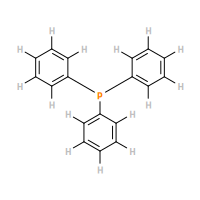

HC1Ph  AF = 19.91 +/- 6.86


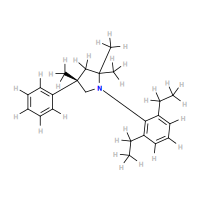

HI  AF = 3.45 +/- 1.71


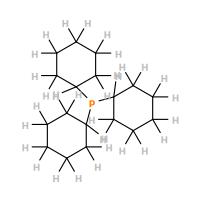

HII  AF = 14.95 +/- 0.02


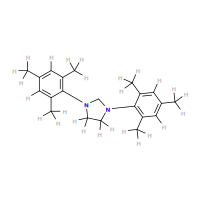

HIIprime  AF = 13.66 +/- 0.01


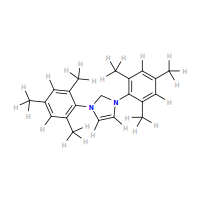

In [7]:
# Display the chemical structure of the ligands and the mean+std
from openbabel import pybel
from IPython.display import SVG, display

all_ligands = {}
for pathname_to_L in sorted(glob.glob('*/*-0_outSubXTB-L.sdf')):
    for mol in pybel.readfile('sdf', pathname_to_L):
        name = os.path.basename(pathname_to_L).replace('-0_outSubXTB-L.sdf','')
        mol.title = ""
        all_ligands[name] = mol


for index, row in df_summary.iterrows():
    print("%s  AF = %.2f +/- %.2f" % (index, row['mean'], row['std']))
    display(SVG(all_ligands[index].write("svg")))

Inspect data for series with large standard deviation: 'HC1Ph'

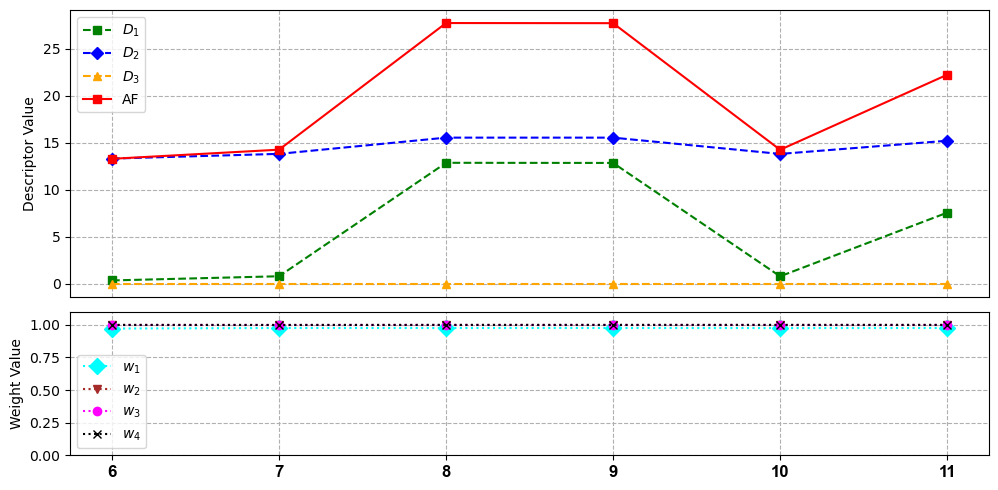

In [8]:
plot_one_series('HC1Ph')

In [9]:
get_values_for_series(['freeEnergyD','freeEnergyX','freeEnergyZ'],'HC1Ph')

    freeEnergyD  freeEnergyX  freeEnergyZ
6  -2080.108150 -2158.613039 -2080.059045
7  -2080.108135 -2158.613180 -2080.058389
8  -2080.108135 -2158.613181 -2080.055640
9  -2080.108135 -2158.613181 -2080.055640
10 -2080.108155 -2158.613181 -2080.058398
11 -2080.108135 -2158.613181 -2080.056167


The other entry with large standard deviation is 'HI'

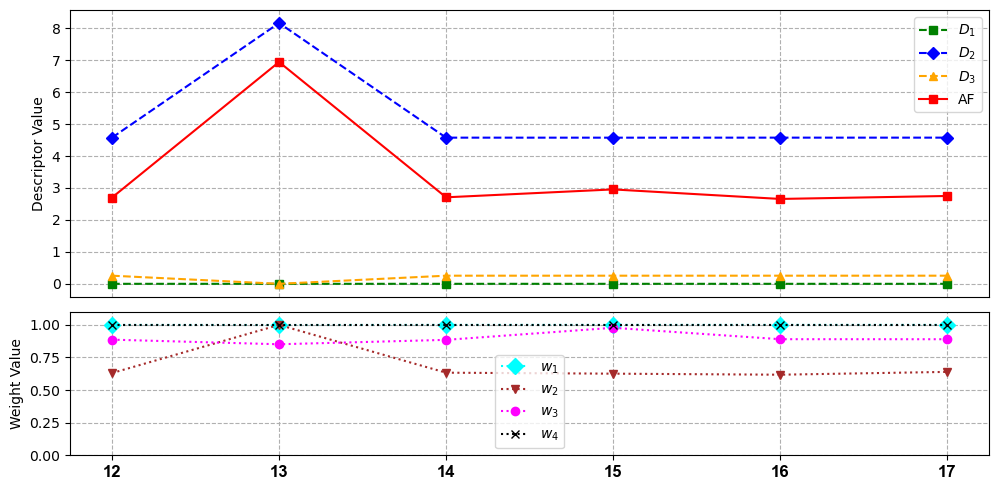

In [10]:
plot_one_series('HI')

In [11]:
get_values_for_series(['freeEnergyD','freeEnergyX','freeEnergyZ'],'HI')

    freeEnergyD  freeEnergyX  freeEnergyZ
12 -2178.704145 -2257.215056 -2178.674986
13 -2178.711560 -2257.219769 -2178.673982
14 -2178.704145 -2257.215056 -2178.674987
15 -2178.704145 -2257.215056 -2178.674988
16 -2178.704145 -2257.215056 -2178.674987
17 -2178.704145 -2257.215056 -2178.674986
